# Predicting Financial Time Series Data with Machine Learning

This is a sample that predicts future prices from past price movements.
Here we implement it with EUR/USD rate as an example, but you can convert it to stock price by editing the symbol.


In [1]:
import datetime
import numpy as np
import pandas as pd
from matplotlib.finance import quotes_historical_yahoo_ochl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display
%matplotlib inline

# time period
d1 = datetime.datetime(2008, 1, 1)
d2 = datetime.datetime(2016, 12, 31)

# Fetching data from yahoo finance
# List of Symbols : http://finance.yahoo.com/webservice/v1/symbols/allcurrencies/quote 
q = quotes_historical_yahoo_ochl('EUR=X', d1, d2, asobject=True)

,date,open,close,high,low,volume,aclose
0,2008-01-01,1.460110,1.462010,1.458194,1.462994,0.0,1.462010
1,2008-01-02,1.462309,1.471692,1.460110,1.474296,0.0,1.471692
2,2008-01-03,1.471692,1.474491,1.469400,1.477891,0.0,1.474491
3,2008-01-04,1.474709,1.475492,1.469897,1.481811,0.0,1.475492
4,2008-01-07,1.475209,1.468299,1.466706,1.475209,0.0,1.468299


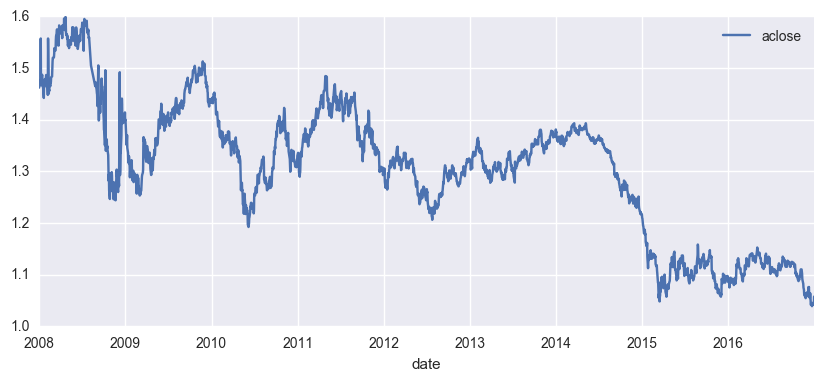

In [2]:
# Put data into Pandas Dataframe
df = pd.DataFrame(q)
df.drop(['year','month','day','d'], inplace=True, axis=1)
df[['open','high','low','close','aclose']] = df[['open','high','low','close','aclose']].applymap(lambda x: 1.0/x)
display(df.head())
df.plot(x='date', y='aclose', figsize=(10,4))

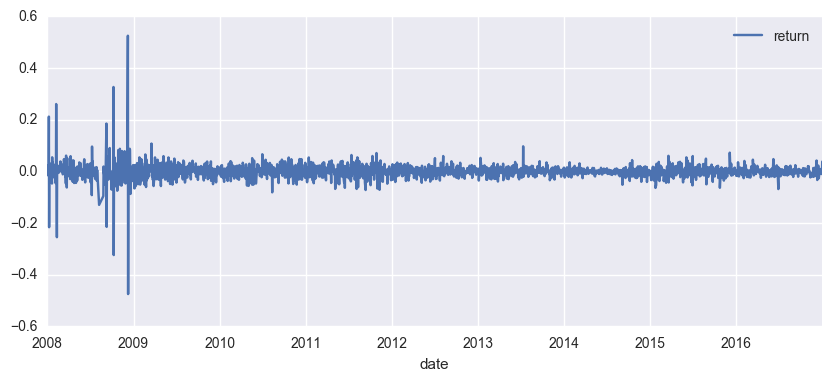

In [3]:
# Normalize aclose value
# We use this value to train model

df['return'] = df['aclose'] - df['aclose'].shift(1)
return_range = df['return'].max() - df['return'].min()
df['return'] = df['return'] / return_range

df.plot(x='date', y='return', figsize=(10,4))

In [4]:
# Make label, 1 as rising price, 0 as falling price

df['label'] = df['return'].shift(-1)
df['label'] = df['label'].apply(lambda x: 1 if x>0.0 else 0)
# df.dropna(inplace=True)
df.tail()

,date,open,close,high,low,volume,aclose,return,label
2322,2016-12-26,1.045588,1.045478,1.044600,1.047011,0.0,1.045478,0.004086,1
2323,2016-12-27,1.045577,1.045697,1.043536,1.046135,0.0,1.045697,0.000521,1
2324,2016-12-28,1.046244,1.046233,1.038745,1.048218,0.0,1.046233,0.001279,0
2325,2016-12-29,1.041775,1.041699,1.041775,1.049098,0.0,1.041699,-0.010813,1
2326,2016-12-30,1.056904,1.057530,1.051000,1.059098,0.0,1.057530,0.037754,0


In [5]:
# Make training dataset

n_features = 60 # number of features

train_x = np.array([]).reshape([-1,n_features])
train_y = np.array([]).reshape([-1,1])
for index, row in df.iterrows():
    i = df.index.get_loc(index)
    if i<n_features:
        continue
    
    _x = np.array(df[i-n_features+1:i+1]['return']).T.reshape([1, -1])
    _y = df.ix[i]['label']
    train_x = np.vstack((train_x, _x))
    train_y = np.vstack((train_y, _y))
train_y = train_y.reshape([-1])
print(train_x.shape)
print(train_y.shape)
print('%% of Class0 : %f' % (np.count_nonzero(train_y == 0)/float(len(train_y))))
print('%% of Class1 : %f' % (np.count_nonzero(train_y == 1)/float(len(train_y))))

(2267, 60)
(2267,)
% of Class0 : 0.507278
% of Class1 : 0.492722


In [6]:
# Define Model and fit
# Here we use 95% of data for training, and last 5% for testing

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0, learning_rate=0.01, n_estimators=10000)

train_len = int(len(train_x)*0.95)
clf.fit(train_x[:train_len], train_y[:train_len])

accuracy = clf.score(train_x[train_len:], train_y[train_len:])
print('Testing Accuracy: %f' % accuracy)

Testing Accuracy: 0.587719


,return,label,pred,won,pnl,equity
108,0.001713,1.0,0.0,False,-17.132370,1001.844714
109,0.000219,1.0,0.0,False,-2.186507,999.658207
110,0.000536,1.0,0.0,False,-5.360809,994.297398
111,-0.004534,0.0,0.0,True,45.338182,1039.635580
112,0.015830,1.0,1.0,True,158.303911,1197.939490


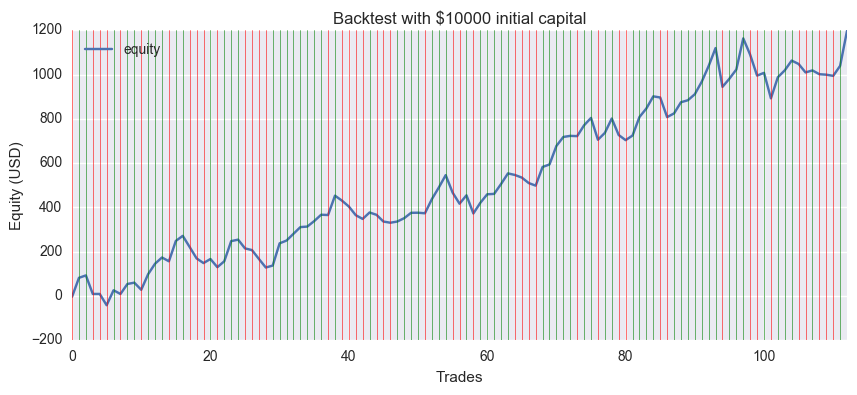

In [7]:
# Predict test data

pred = clf.predict(train_x[train_len:])


# Calculate equity..

contracts  = 10000.0
commission = 0.0


df_trade = pd.DataFrame(train_x[train_len:,-1], columns=['return'])
df_trade['label']  = train_y[train_len:]
df_trade['pred']   = pred
df_trade['won']    = df_trade['label'] == df_trade['pred']
df_trade['return'] = df_trade['return'].shift(-1) * return_range
df_trade.drop(df_trade.index[len(df_trade)-1], inplace=True)

def calc_profit(row):
    if row['won']:
        return abs(row['return'])*contracts - commission
    else:
        return -abs(row['return'])*contracts - commission

df_trade['pnl'] = df_trade.apply(lambda row: calc_profit(row), axis=1)
df_trade['equity'] = df_trade['pnl'].cumsum()

display(df_trade.tail())
df_trade.plot(y='equity', figsize=(10,4), title='Backtest with $10000 initial capital')
plt.xlabel('Trades')
plt.ylabel('Equity (USD)')
for r in df_trade.iterrows():
    if r[1]['won']:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='g')
    else:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='r')

Net Profit            : $1197.94
Number Winning Trades : 67
Number Losing Trades  : 45
Percent Profitable    : 59.82%
Avg Win Trade         : $43.835
Avg Los Trade         : $-38.644
Largest Win Trade     : $158.304
Largest Los Trade     : $-175.304
Profit Factor         : 1.69


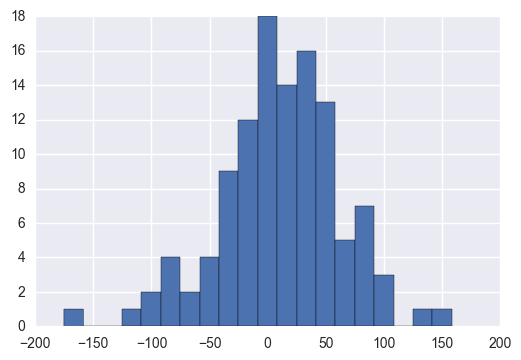

In [8]:
# Calculate summary of trades

n_win_trades = float(df_trade[df_trade['pnl']>0.0]['pnl'].count())
n_los_trades = float(df_trade[df_trade['pnl']<0.0]['pnl'].count())
print("Net Profit            : $%.2f" % df_trade.tail(1)['equity'])
print("Number Winning Trades : %d" % n_win_trades)
print("Number Losing Trades  : %d" % n_los_trades)
print("Percent Profitable    : %.2f%%" % (100*n_win_trades/(n_win_trades + n_los_trades)))
print("Avg Win Trade         : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].mean())
print("Avg Los Trade         : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].mean())
print("Largest Win Trade     : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].max())
print("Largest Los Trade     : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].min())
print("Profit Factor         : %.2f" % abs(df_trade[df_trade['pnl']>0.0]['pnl'].sum()/df_trade[df_trade['pnl']<0.0]['pnl'].sum()))

df_trade['pnl'].hist(bins=20)